### Learning how to read and write out to files in different directories

In [18]:
# file_object = open('/home/samantha/fsps/data/imf.dat', 'r')
# content = file_object.read()
# file_object.close()

In [20]:
file_object.close()

In [120]:
# with open('/home/samantha/fsps/data/imf_copy.dat', 'w') as f:
#     f.write('0.08 0.50 1.3\n0.50 1.00 2.3\n1.00 100. 2.3\n') # <- content ^

In [3]:
# Actually changing the imf.dat file
with open('/home/samantha/fsps/data/imf.dat', 'w') as f:
    f.write('0.08 0.50 1.3\n0.50 1.00 2.3\n1.00 100. 2.3\n') # <- content ^
with open('/home/samantha/fsps/data/imf.dat', 'r') as f:
    content = f.read()
    print(content)

0.08 0.50 1.3
0.50 1.00 2.3
1.00 100. 2.3



In [123]:
with open('/home/samantha/fsps/data/imf.dat', 'r') as f:
    lines = f.readlines()

In [124]:
for line in lines:
    print(line, end='')

0.08 0.50 1.3
0.50 1.00 2.3

-------------
### Changing upper and lower limits on IMF

In [48]:
from matplotlib.pyplot import *
import numpy as np
from prospectFunctions import getObs, getWave, getParams, getModel, getSps
import itertools
import astropy.units as u
import astropy.constants as const
import time
from tqdm import tqdm

In [94]:
imf_type = 5

imf_types = ['Salpeter (1955)', 'Chabrier (2003)', 'Kroupa (2001)', 'van Dokkum (2008)', 'Dave (2008)']

grid_ranges, run_params = getParams(imf_type=imf_type, len_logz=100, len_dust=6, len_tage=100, dust=True)
a = 1.0 + run_params['zred']

logzs = grid_ranges['logzsol']
dusts = grid_ranges['dust2']
tages = grid_ranges['tage']

num_models = len(logzs)*len(dusts)*len(tages)

obs = getObs(**run_params)
sps = getSps(**run_params)
wspec, wphot = getWave(obs=obs, sps=sps, **run_params)

In [95]:
run_params['logzsol'], run_params['dust2'], run_params['tage'] = grid_ranges['logzsol'][0], grid_ranges['dust2'][0], grid_ranges['tage'][0]
run_params

{'imf_type': 5,
 'zred': 3.548,
 'mass': 100000000.0,
 'add_duste': False,
 'zcontinuous': 1,
 'logzsol': np.float64(-1.0),
 'dust2': np.float64(0.0),
 'tage': np.float64(0.1)}

In [3]:
data_grid_params = np.empty([len(logzs),len(dusts),len(tages),5])
data_grid_spec = np.empty([len(logzs),len(dusts),len(tages),len(wspec)])

In [ ]:
# for i_logz,i_dust,i_tage in tqdm(itertools.product(range(len(logzs)),range(len(dusts)),range(len(tages)))):
    
#     logz = grid_ranges['logzsol'][i_logz]
#     dust = grid_ranges['dust2'][i_dust]
#     tage = grid_ranges['tage'][i_tage]

#     run_params['tage'] = tage
#     run_params['dust2'] = dust
#     run_params['logzsol'] = logz

#     model = getModel(**run_params)
    
#     init_spec, init_phot, init_mfrac = model.predict(model.theta, obs=obs, sps=sps)

#     data_grid_params[i_logz, i_dust, i_tage, :] = [run_params['zred'], run_params['mass'], logz, dust, tage]
#     data_grid_spec[i_logz, i_dust, i_tage, :] = init_spec

In [96]:
def getModel(mass=None, zred=None, logzsol=None, tage=None, dust2=None, imf_type=2, **extras):
    """Build a prospect.models.SpecModel object

    :param mass: (optional, default:None)
        If given, produce spectra for this mass. Otherwise the mass will
        be 1e10 solar masses.

    :param zred: (optional, default: None)
        If given, produce spectra and observed frame photometry appropriate
        for this redshift. Otherwise the redshift will be zero.

    :param logzsol: (optional, default: None)
        If given, fix the model metallicity (:math: `log(Z/Z_sun)`) to the given value.
        Otherwise the metallicity will be set to -0.5.
        
    :param tage: (optional, default: None)
        If given, produce spectra and model photometry appropriate for
        this galactic age. Otherwise the age will be set to 13. Gyrs.

    :param dust2: (optional, default: None)
        If given, produce spectra that are appropriate for provided dust
        attenuation. Otherwise attenuation will be set to 0.6.

    :returns model:
        An instance of prospect.models.SedModel
    """
    from prospect.models import SpecModel
    from prospect.models.templates import TemplateLibrary

    model_params = TemplateLibrary['ssp']

    # Change `isfree` so that all parameters that will be kept track of are identified 
    # in the `model` object as `free_params`
    model_params['zred']['isfree'] = True

    if zred is None:
        model_params['zred']['init'] = 0.0
    else:
        model_params['zred']['init'] = zred

    if mass is not None:
        model_params['mass']['init'] = mass

    if logzsol is not None:
        model_params['logzsol']['init'] = logzsol

    if tage is None:
        model_params['tage']['init'] = 13.
    else:
        model_params['tage']['init'] = tage

    if dust2 is not None:
        model_params['dust2']['init'] = dust2

    model_params['imf_type']['init'] = imf_type
    # model_params['imf_type']['isfree'] = True

    model = SpecModel(model_params)

    return model

model = getModel(**run_params)
model

:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  zred: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=4.0)
  mass: <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  sfh: [0] 
  imf_type: [5] 
  dust_type: [0] 

In [97]:
init_spec, init_phot, init_mfrac = model.predict(model.theta, obs=obs, sps=sps)

In [5]:
data_grid_spec = np.load('specs_imf_2_60000.npy')

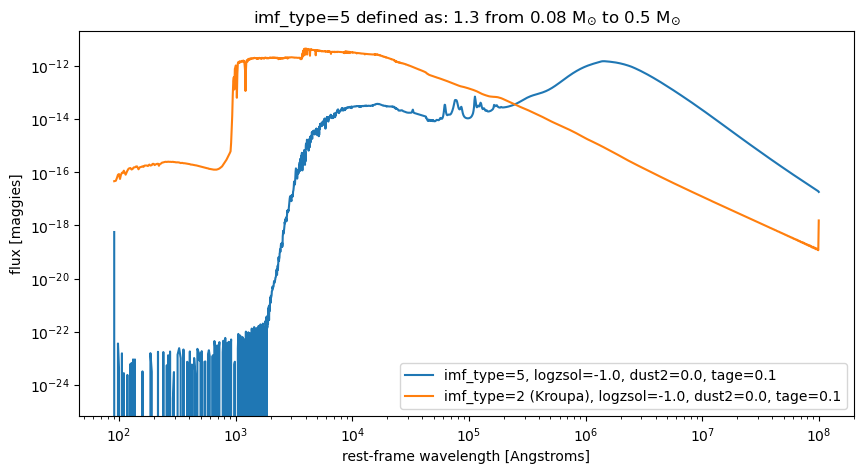

In [21]:
figure(figsize=(10,5))

plot(wspec/a, init_spec, label=f'imf_type=5, logzsol={logzs[0]}, dust2={dusts[0]}, tage={tages[0]}')

plot(wspec/a, data_grid_spec[0,0,0,:], label=f'imf_type=2 (Kroupa), logzsol={logzs[0]}, dust2={dusts[0]}, tage={tages[0]}')

yscale('log')

xlabel('rest-frame wavelength [Angstroms]')
ylabel('flux [maggies]')

a = 1.0 + run_params['zred']

# xlim([1000,45000])
xscale('log')

title_text = r'imf_type=5 defined as: 1.3 from 0.08 M$_{\odot}$ to 0.5 M$_{\odot}$'
title(title_text)
legend()

# savefig('test_custom_imf.png')

show()

In [61]:
x = np.linspace(0.08,0.5,10)
y = np.power(x, -1.3) * (np.power(0.5,-12.3)/np.power(0.5,-1.3))
#y = np.logspace(np.log10(.08**(-1.3)),np.log10(0.5**(-1.3)),10)

x2 = np.linspace(0.5,1,10)
y2 = np.power(x2, -12.3) #np.logspace(np.log10(0.5**(-2.3)),np.log10(1**(-2.3)),10)

x3 = np.linspace(1.0,120,10)
y3 = np.power(x3, -2.3) #np.logspace(np.log10(1**(-2.3)),np.log10(120**(-2.3)),10)

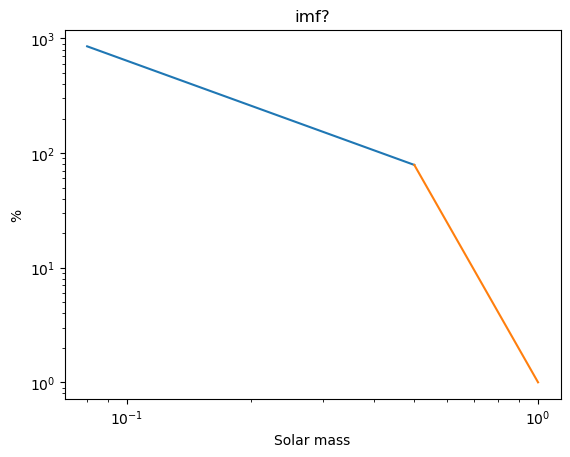

In [64]:
loglog(x,y)
loglog(x2,y2)
# loglog(x3,y3)

# xscale('log')
# yscale('log')

xlabel('Solar mass')
ylabel('%')

title_text = f'imf?'
title(title_text)
show()

------
#### Actually trying it out

In [5]:
from matplotlib.pyplot import *
import numpy as np
from prospectFunctions import getObs, getWave, getParams, getModel, getSps
import itertools
import astropy.units as u
import astropy.constants as const
import time
from tqdm import tqdm

In [35]:
imf_type = 5

# imf_types = ['Salpeter (1955)', 'Chabrier (2003)', 'Kroupa (2001)', 'van Dokkum (2008)', 'Dave (2008)']

grid_ranges, run_params = getParams(imf_type=imf_type, len_logz=100, len_dust=6, len_tage=100, dust=True)
a = 1.0 + run_params['zred']

logzs = grid_ranges['logzsol']
dusts = grid_ranges['dust2']
tages = grid_ranges['tage']

num_models = len(logzs)*len(dusts)*len(tages)

obs = getObs(**run_params)
sps = getSps(**run_params)
wspec, wphot = getWave(obs=obs, sps=sps, **run_params)

In [65]:
specs = []

imf_type = 5
run_params['imf_type'] = imf_type
run_params['logzsol'] = logzs[0]
run_params['dust2'] = dusts[0]
run_params['tage'] = tages[0]
test_imfs = ['0.08 0.50 1.3',
             '0.08 0.50 1.3\n0.50 1.00 2.3',
             '0.08 0.50 1.3\n0.50 1.00 12.3',
             '0.08 0.50 1.3\n0.50 1.00 2.3\n1.00 120. 2.3\n']

for test in tqdm(test_imfs):
    with open('/home/samantha/fsps/data/imf.dat', 'w') as f:
        f.write(test) # <- content ^

    with open('/home/samantha/fsps/data/imf.dat', 'r') as f:
        content = f.read()
        print(content)
        print()

    sps = getSps(**run_params)

    model = getModel(**run_params)
    init_spec, init_phot, init_mfrac = model.predict(model.theta, obs=obs, sps=sps)

    specs.append(init_spec)

  0%|                                                                                   | 0/4 [00:00<?, ?it/s]

0.08 0.50 1.3



 25%|██████████████████▊                                                        | 1/4 [00:48<02:24, 48.02s/it]

0.08 0.50 1.3
0.50 1.00 2.3



 50%|█████████████████████████████████████▌                                     | 2/4 [01:36<01:36, 48.18s/it]

0.08 0.50 1.3
0.50 1.00 12.3



 75%|████████████████████████████████████████████████████████▎                  | 3/4 [02:24<00:48, 48.18s/it]

0.08 0.50 1.3
0.50 1.00 2.3
1.00 120. 2.3




100%|███████████████████████████████████████████████████████████████████████████| 4/4 [03:13<00:00, 48.26s/it]


In [66]:
run_params

{'imf_type': 5,
 'zred': 3.548,
 'mass': 100000000.0,
 'add_duste': False,
 'zcontinuous': 1,
 'logzsol': np.float64(-1.0),
 'dust2': np.float64(0.0),
 'tage': np.float64(0.1)}

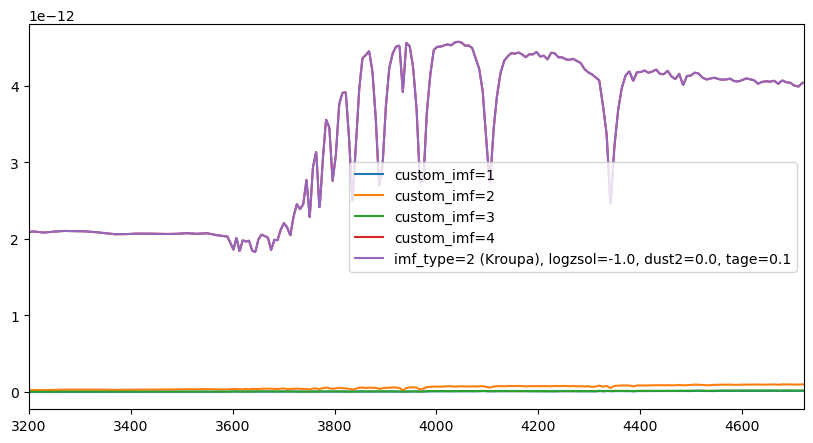

In [67]:
figure(figsize=(10,5))

n=1
for spec in specs:
    loglog(wspec/a,spec, label=f'custom_imf={n}')
    n+=1

loglog(wspec/a, data_grid_spec[0,0,0,:], label=f'imf_type=2 (Kroupa), logzsol={logzs[0]}, dust2={dusts[0]}, tage={tages[0]}')

xlim([3200,4720])
xscale('linear')
yscale('linear')
# ylim([1e-16,1e-11])

legend()

show()

------
#### Actually trying it out (again but changing imf_upper & imf_lower bounds)

In [1]:
from matplotlib.pyplot import *
import numpy as np
from prospectFunctions import getObs, getWave, getParams, getModel, getSps
import itertools
import astropy.units as u
import astropy.constants as const
import time
from tqdm import tqdm

In [2]:
imf_type = 5

# imf_types = ['Salpeter (1955)', 'Chabrier (2003)', 'Kroupa (2001)', 'van Dokkum (2008)', 'Dave (2008)']

grid_ranges, run_params = getParams(imf_type=imf_type, len_logz=100, len_dust=6, len_tage=100, dust=True)
a = 1.0 + run_params['zred']

logzs = grid_ranges['logzsol']
dusts = grid_ranges['dust2']
tages = grid_ranges['tage']

num_models = len(logzs)*len(dusts)*len(tages)

obs = getObs(**run_params)
sps = getSps(**run_params)
wspec, wphot = getWave(obs=obs, sps=sps, **run_params)

In [24]:
specs = []

run_params['imf_type'] = imf_type
run_params['logzsol'] = logzs[0]
run_params['dust2'] = dusts[0]
run_params['tage'] = tages[0]

test_imfs = ['0.08 0.50 1.3\n0.50 1.00 2.3\n1.00 120. 2.3\n',
             '0.008 0.50 1.3\n0.50 1.00 2.3\n1.00 120. 2.3\n',
             '0.08 0.50 1.3\n0.50 1.00 2.3\n1.00 300. 2.3\n',
             '0.008 0.50 1.3\n0.50 1.00 2.3\n1.00 300. 2.3\n']

for test in tqdm(test_imfs):
    with open('/home/samantha/fsps/data/imf.dat', 'w') as f:
        f.write(test) # <- content ^

    with open('/home/samantha/fsps/data/imf.dat', 'r') as f:
        content = f.read()
        print(content)
        print()

    sps = getSps(**run_params)

    model = getModel(**run_params)
    init_spec, init_phot, init_mfrac = model.predict(model.theta, obs=obs, sps=sps)

    specs.append(init_spec)

  0%|                                                                                   | 0/4 [00:00<?, ?it/s]

0.08 0.50 1.3
0.50 1.00 2.3
1.00 120. 2.3




 25%|██████████████████▊                                                        | 1/4 [00:48<02:25, 48.56s/it]

0.008 0.50 1.3
0.50 1.00 2.3
1.00 120. 2.3




 50%|█████████████████████████████████████▌                                     | 2/4 [01:34<01:34, 47.14s/it]

0.08 0.50 1.3
0.50 1.00 2.3
1.00 300. 2.3




 75%|████████████████████████████████████████████████████████▎                  | 3/4 [02:23<00:47, 47.94s/it]

0.008 0.50 1.3
0.50 1.00 2.3
1.00 300. 2.3




100%|███████████████████████████████████████████████████████████████████████████| 4/4 [03:10<00:00, 47.70s/it]


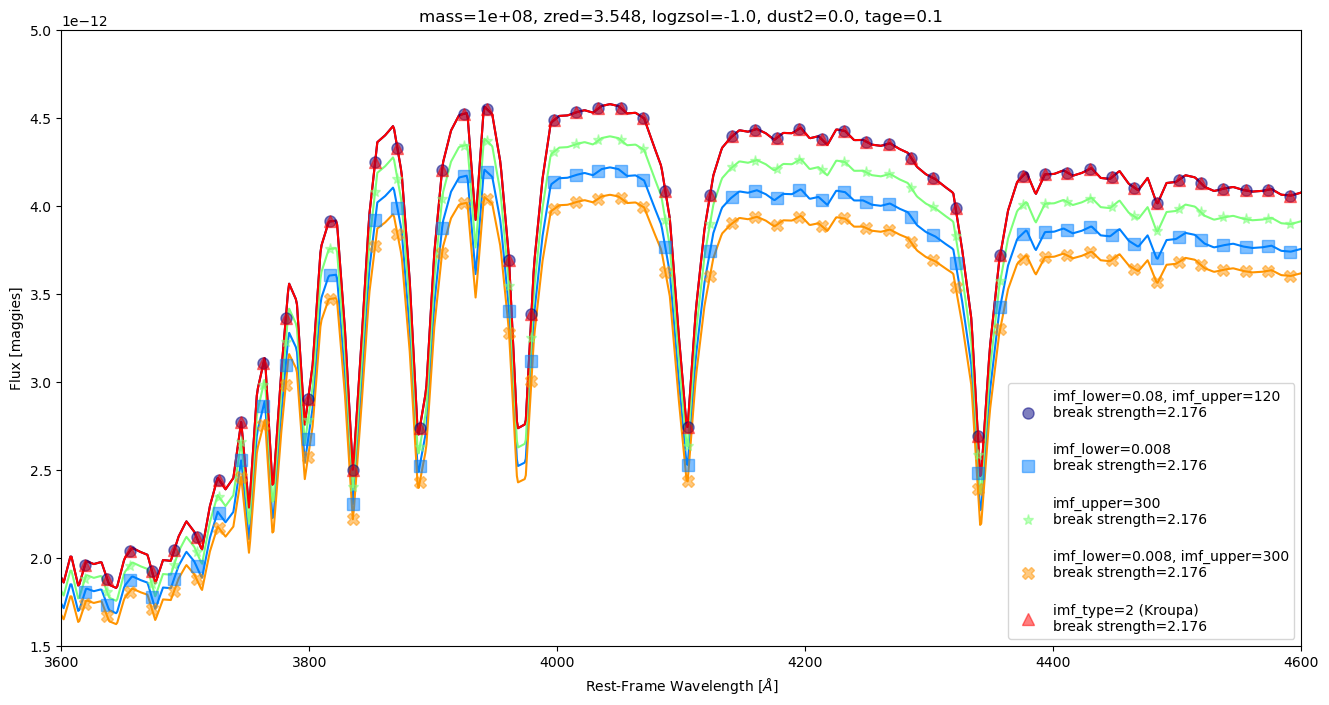

In [149]:
figure(figsize=(16,8))

color = cm.jet(np.linspace(0, 1, 5))

markers = ['o', 's', '*', 'X', '^']
type_of_imf=['imf_lower=0.08, imf_upper=120', 'imf_lower=0.008', 'imf_upper=300', 'imf_lower=0.008, imf_upper=300']

for n, spec in enumerate(specs):
    loglog(wspec/a, spec, markers[n], markevery=20, color=color[n], label=f'{type_of_imf[n]}\nbreak strength={data_grid_break[n]:.3f}\n', alpha=0.5, ms=8, zorder=12)
    loglog(wspec/a, spec, color=color[n])

loglog(wspec/a, data_grid_spec[0,0,0,:], markers[-1], markevery=20, color='red', label=f'imf_type=2 (Kroupa)\nbreak strength={data_grid_break[-1]:.3f}', alpha=0.5, ms=8, zorder=12)
loglog(wspec/a, data_grid_spec[0,0,0,:], color='red')

xlim([3600,4600])
xscale('linear')
yscale('linear')
ylim([1.5e-12,5e-12])

xlabel(r'Rest-Frame Wavelength [$\AA$]')
ylabel('Flux [maggies]')

title_text = f'mass={run_params['mass']:.0e}, zred={run_params['zred']}, logzsol={logzs[0]}, dust2={dusts[0]}, tage={tages[0]}'
title(title_text)

legend()

# savefig('adjusting_imf_bounds.png')

show()

In [103]:
from prospectFunctions import *

In [104]:
help(getBreakBounds)

Help on function getBreakBounds in module prospectFunctions:

getBreakBounds(wspec, start, zred=None, **extras)



In [108]:
getBreakBounds(wspec, 3620, **run_params)

{'blue': [382, 493], 'red': [804, 915]}

In [113]:
wspec[382:493][[0,-1]]/a, wspec[804:915][[0,-1]]/a, 

(array([3620.7322, 3719.7578]), array([4000.6309, 4099.6568]))

In [138]:
blue_lower, blue_upper = 382, 493
red_lower, red_upper = 804, 915

data_grid_break = np.empty(5)

for i_model in range(len(specs)):
    lower = specs[i_model][blue_lower:blue_upper].mean()
    upper = specs[i_model][red_lower:red_upper].mean()

    ratio = upper/lower

    data_grid_break[i_model] = ratio

data_grid_break[-1] = data_grid_spec[0,0,0,red_lower:red_upper].mean() / data_grid_spec[0,0,0,blue_lower:blue_upper].mean()

In [139]:
data_grid_break

array([2.17580257, 2.17580257, 2.17580257, 2.17580257, 2.17580257])

In [116]:
run_params

{'imf_type': 5,
 'zred': 3.548,
 'mass': 100000000.0,
 'add_duste': False,
 'zcontinuous': 1,
 'logzsol': np.float64(-1.0),
 'dust2': np.float64(0.0),
 'tage': np.float64(0.1)}